In [51]:
# for loading/processing the images  
import tensorflow as tf

from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from tensorflow.keras.applications import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score,homogeneity_score,silhouette_score,silhouette_samples


# Defining the model 



*   Je vais  utiliser un dataset aribtraire, exemple : Flower dataset dans Kaggle après on change ça avec notre propore dataset 

*   Ajout de pooling pour réduire la dimension 
*   Utilisation d'un VGG au lieu d'un Resnet 
*   Réduire les dimesnions avec un PCA 
*   application de Kmeans pour culstering










In [3]:
model = VGG16(include_top=True,weights='imagenet',input_shape=(224,224,3),pooling='max')

553476096/553467096 [==============================] - 5s 0us/step


In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls

drive  sample_data


In [8]:
base_dir = "/content/drive/My Drive/flowers"

In [9]:
flowers = []

list_of_files = sorted( filter( lambda x: os.path.isfile(os.path.join(base_dir, x)),
                        os.listdir(base_dir) ) )
for file in list_of_files : 
  if file.endswith('.png'):
    flowers.append(file)

In [10]:
flowers

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

# Data Preprocessing

In [11]:
import os
os.chdir(base_dir)

img = load_img(flowers[0], target_size=(224,224))
# convert from 'PIL.Image.Image' to numpy array
img = np.array(img)

print(img.shape)


(224, 224, 3)


In [12]:
# reshaping the images 
reshaped_img = img.reshape(1,224,224,3)
print(reshaped_img.shape)

(1, 224, 224, 3)


In [13]:

def get_features(file, model):
    # get l'image  224x224 
    img = load_img(file, target_size=(224,224))
    # convertir l'image en numpy
    img = np.array(img) 
    # batch_size = 1, taille = 224x224 , channel = 3
    reshaped_img = img.reshape(1,224,224,3) 
    # passage vers le modele
    imgx = preprocess_input(reshaped_img)
    # get le vecteur de feature
    features = model.predict(imgx, use_multiprocessing=True)
    return features


In [14]:
# boucle sur l'ensemble des images

data = {}

for flower in flowers:
  feat = get_features(flower,model)
  data[flower] = feat

filenames = np.array(list(data.keys()))

# liste des features
feat = np.array(list(data.values()))
feat.shape



(210, 1, 4096)

In [15]:
feat = feat.reshape(-1,4096)
feat.shape

(210, 4096)

# PCA

In [16]:
#application de PCA
pca = PCA(n_components=150, random_state=42)
pca.fit(feat)
x = pca.transform(feat)

# Kmeans 




In [17]:
kmeans = KMeans(n_clusters=10,init='k-means++')
kmeans.fit(x)

KMeans(n_clusters=10)

In [18]:
kmeans.labels_


array([4, 4, 2, 1, 1, 7, 0, 1, 1, 1, 0, 1, 4, 4, 4, 7, 4, 1, 0, 0, 2, 3,
       4, 2, 5, 6, 2, 0, 9, 4, 8, 6, 0, 5, 9, 1, 0, 4, 2, 0, 8, 1, 4, 1,
       7, 3, 4, 1, 1, 7, 8, 3, 4, 8, 4, 6, 5, 4, 0, 1, 2, 7, 4, 4, 1, 5,
       6, 1, 9, 3, 5, 4, 8, 7, 5, 1, 6, 0, 1, 9, 7, 3, 9, 5, 1, 5, 2, 3,
       6, 3, 4, 7, 5, 2, 7, 0, 4, 5, 1, 8, 7, 2, 3, 5, 8, 2, 1, 0, 1, 4,
       0, 3, 2, 8, 5, 4, 1, 6, 1, 4, 5, 2, 3, 5, 7, 1, 2, 1, 1, 6, 5, 2,
       7, 3, 0, 1, 1, 6, 2, 3, 8, 3, 4, 0, 2, 4, 4, 3, 9, 9, 2, 3, 4, 0,
       8, 8, 9, 0, 9, 4, 0, 8, 9, 4, 1, 1, 4, 8, 8, 5, 8, 7, 8, 8, 1, 5,
       7, 3, 2, 4, 4, 5, 1, 6, 4, 4, 6, 1, 9, 0, 3, 4, 7, 5, 1, 9, 6, 5,
       6, 3, 9, 8, 0, 4, 3, 9, 1, 3, 4, 9], dtype=int32)

In [19]:

groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [20]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    files = groups[cluster]
    # Affichage d'un ensemble de 30
    
    # Afficher chaque image dans son cluster 
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

['0007.png',
 '0011.png',
 '0019.png',
 '0020.png',
 '0028.png',
 '0033.png',
 '0037.png',
 '0040.png',
 '0059.png',
 '0078.png',
 '0096.png',
 '0108.png',
 '0111.png',
 '0135.png',
 '0144.png',
 '0154.png',
 '0158.png',
 '0161.png',
 '0190.png',
 '0203.png']

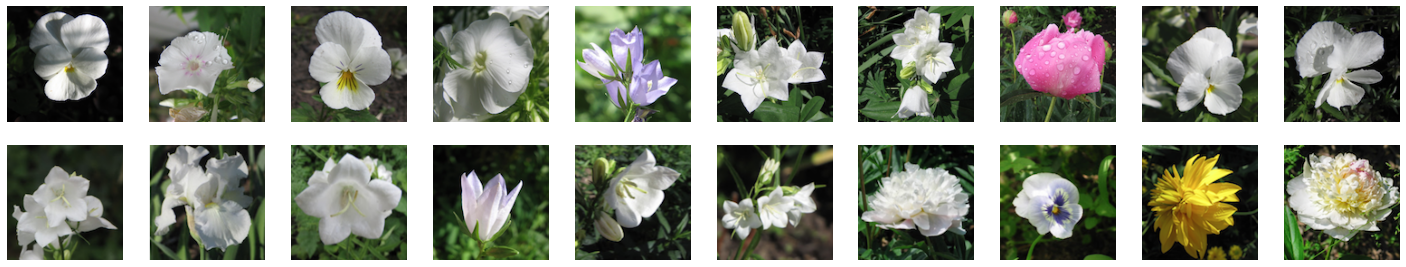

In [21]:
view_cluster(0)
len(groups[0])
groups[0]

['0029.png',
 '0035.png',
 '0069.png',
 '0080.png',
 '0083.png',
 '0149.png',
 '0150.png',
 '0157.png',
 '0159.png',
 '0163.png',
 '0189.png',
 '0196.png',
 '0201.png',
 '0206.png',
 '0210.png']

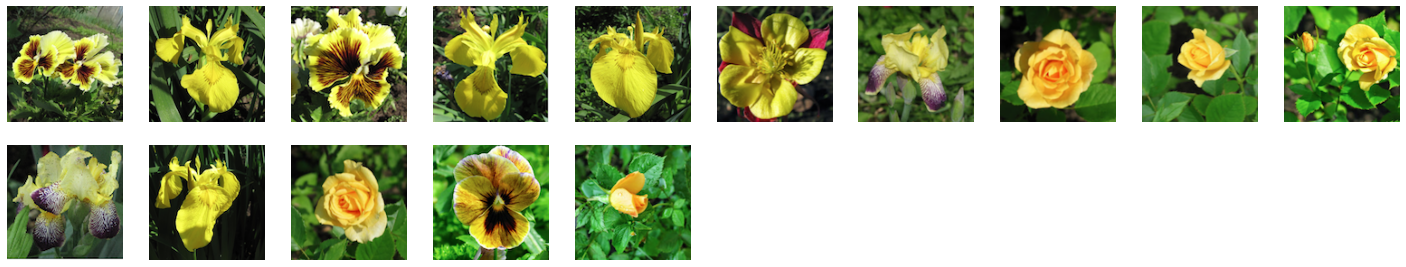

In [22]:
view_cluster(9)
groups[9]

['0022.png',
 '0046.png',
 '0052.png',
 '0070.png',
 '0082.png',
 '0088.png',
 '0090.png',
 '0103.png',
 '0112.png',
 '0123.png',
 '0134.png',
 '0140.png',
 '0142.png',
 '0148.png',
 '0152.png',
 '0178.png',
 '0191.png',
 '0200.png',
 '0205.png',
 '0208.png']

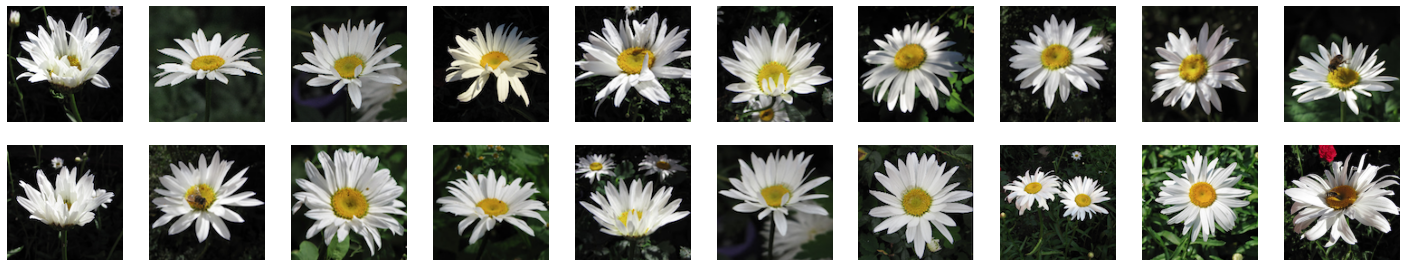

In [23]:
view_cluster(3)
groups[3]

In [24]:
groups[0][0]

'0007.png'

In [25]:
x.shape

(210, 150)

In [26]:
df = pd.read_csv('flower_labels.csv')
label = df['label'].tolist()
y_test = np.array(label)
accuracy_score(kmeans.labels_,y_test)*100



23.809523809523807

In [27]:
filename = df['file'].tolist()
filename

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

In [28]:
flowers

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png',
 '0011.png',
 '0012.png',
 '0013.png',
 '0014.png',
 '0015.png',
 '0016.png',
 '0017.png',
 '0018.png',
 '0019.png',
 '0020.png',
 '0021.png',
 '0022.png',
 '0023.png',
 '0024.png',
 '0025.png',
 '0026.png',
 '0027.png',
 '0028.png',
 '0029.png',
 '0030.png',
 '0031.png',
 '0032.png',
 '0033.png',
 '0034.png',
 '0035.png',
 '0036.png',
 '0037.png',
 '0038.png',
 '0039.png',
 '0040.png',
 '0041.png',
 '0042.png',
 '0043.png',
 '0044.png',
 '0045.png',
 '0046.png',
 '0047.png',
 '0048.png',
 '0049.png',
 '0050.png',
 '0051.png',
 '0052.png',
 '0053.png',
 '0054.png',
 '0055.png',
 '0056.png',
 '0057.png',
 '0058.png',
 '0059.png',
 '0060.png',
 '0061.png',
 '0062.png',
 '0063.png',
 '0064.png',
 '0065.png',
 '0066.png',
 '0067.png',
 '0068.png',
 '0069.png',
 '0070.png',
 '0071.png',
 '0072.png',
 '0073.png',
 '0074.png',
 '0075.png',
 '0076.png',
 '0077.png',

In [29]:
print(kmeans.labels_)
print(df['label'].tolist())

[4 4 2 1 1 7 0 1 1 1 0 1 4 4 4 7 4 1 0 0 2 3 4 2 5 6 2 0 9 4 8 6 0 5 9 1 0
 4 2 0 8 1 4 1 7 3 4 1 1 7 8 3 4 8 4 6 5 4 0 1 2 7 4 4 1 5 6 1 9 3 5 4 8 7
 5 1 6 0 1 9 7 3 9 5 1 5 2 3 6 3 4 7 5 2 7 0 4 5 1 8 7 2 3 5 8 2 1 0 1 4 0
 3 2 8 5 4 1 6 1 4 5 2 3 5 7 1 2 1 1 6 5 2 7 3 0 1 1 6 2 3 8 3 4 0 2 4 4 3
 9 9 2 3 4 0 8 8 9 0 9 4 0 8 9 4 1 1 4 8 8 5 8 7 8 8 1 5 7 3 2 4 4 5 1 6 4
 4 6 1 9 0 3 4 7 5 1 9 6 5 6 3 9 8 0 4 3 9 1 3 4 9]
[0, 0, 2, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 7, 7, 1, 0, 0, 6, 0, 2, 4, 7, 4, 5, 6, 2, 5, 6, 6, 3, 6, 5, 0, 3, 8, 5, 9, 2, 8, 9, 1, 7, 3, 1, 4, 7, 3, 8, 1, 3, 4, 7, 9, 3, 6, 5, 8, 6, 8, 2, 1, 7, 8, 0, 5, 6, 3, 6, 4, 9, 7, 9, 1, 5, 3, 6, 6, 8, 3, 1, 4, 3, 9, 8, 5, 2, 4, 6, 4, 7, 1, 5, 2, 1, 5, 8, 5, 8, 3, 1, 2, 4, 5, 1, 2, 8, 3, 8, 3, 5, 4, 2, 9, 5, 0, 8, 6, 0, 8, 5, 2, 4, 5, 8, 3, 2, 0, 8, 6, 9, 2, 8, 4, 5, 8, 0, 6, 2, 4, 9, 4, 5, 5, 2, 7, 8, 4, 9, 3, 2, 4, 7, 5, 9, 3, 1, 8, 1, 3, 6, 9, 1, 2, 8, 2, 7, 9, 9, 5, 9, 8, 3, 9, 8, 5, 1, 4, 2, 7, 0, 5, 8, 6, 3, 9, 6, 1, 3, 7, 4,

# Perspectives


*   Test sur le dataset de PMA
*   Utilisation de diffrenetes métrique de mesure (Cosine similarity, etc) 
*   Utilisation d'autre algorithmes de clustering (DGB,random forest, etc) 
*   Utilisation d'autre Backbone de NN pour l'extraction des features




In [30]:
label = df['label'].to_numpy()


# Defining metrics 

In [31]:
def classifier_summary(y_test, y_pred_test):

    
    test_accuracy = np.round(accuracy_score(y_test, y_pred_test),4)*100
    test_precision = np.round(precision_score(y_test, y_pred_test, average='weighted'),4)
    test_recall = np.round(recall_score(y_test, y_pred_test, average='weighted'),4)
    test_F1 = np.round(f1_score(y_test, y_pred_test, average='weighted'),4)
    test_kappa =  np.round(cohen_kappa_score(y_test, y_pred_test),4) 
    homogeneity = np.round(homogeneity_score(y_test, y_pred_test),4)
    test_confusion_matrix = confusion_matrix(y_test,y_pred_test)
    

    
    

    
    print()
    print('------------------------ Test Set Metrics------------------------')
    print()
    print("accuracy : {}%".format(test_accuracy))
    print("F1_score : {}".format(test_F1))
    print("Cohen Kappa Score : {} ".format(test_kappa))
    print("Recall : {}".format(test_recall))
    print("Precision : {}".format(test_precision))
    print("Humogeneity : {}".format(homogeneity))
    print("Confusion Matrix : {}".format(test_confusion_matrix))

    print("-"*80)
    print()

    return homogeneity

In [32]:
kmeans.n_clusters

10

In [33]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    # Loop through the clusters
    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels  



In [34]:
def infer_data_labels(Y_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(Y_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(Y_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [35]:


clusters = [10, 16, 36, 64,144,200]
iner_list = []
homo_list = []
acc_list = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(x)
    
   
    iner_list.append(kmeans.inertia_)
    
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(kmeans, label)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    homo = classifier_summary(label, prediction)
    homo_list.append(homo)

    acc = accuracy_score(label, prediction)
    acc_list.append(acc)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 64.75999999999999%
F1_score : 0.6097
Cohen Kappa Score : 0.6068 
Recall : 0.6476
Precision : 0.6349
Humogeneity : 0.5976
Confusion Matrix : [[17  0  0  0  0  3  0  0  1  0]
 [ 0  0  0  0  0  0  5  0 14  1]
 [ 0  0 18  0  0  0  1  0  0  0]
 [ 9  0  0  6  0  1  2  0  0  4]
 [ 0  0  0  0 21  0  0  0  0  0]
 [ 1  0  0  0  1 21  0  0  0  2]
 [ 3  0  0  0  0  5 12  2  0  1]
 [ 0  0  3  0  0  0  0 12  0  0]
 [ 7  0  0  0  0  2  0  0 17  0]
 [ 2  0  0  0  0  3  0  0  1 12]]
--------------------------------------------------------------------------------


------------------------ Test Set Metrics------------------------

accuracy : 74.76%
F1_score : 0.7388
Cohen Kappa Score : 0.719 
Recall : 0.7476
Precision : 0.7791
Humogeneity : 0.6737
Confusion Matrix : [[17  0  0  0  0  3  0  0  1  0]
 [ 0 19  0  0  0  0  0  0  1  0]
 [ 0  0 17  1  0  0  0  1  0  0]
 [ 9  3  0  8  0  1  0  0  0  1]
 [ 0  0  0  0 21  0  0  0  0  

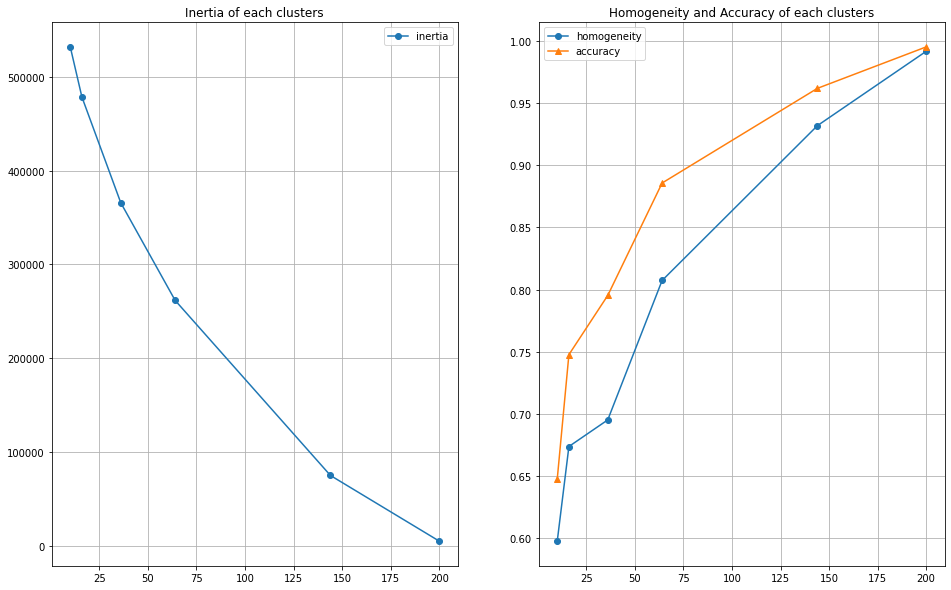

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].plot(clusters, iner_list, label='inertia', marker='o')
ax[1].plot(clusters, homo_list, label='homogeneity', marker='o')
ax[1].plot(clusters, acc_list, label='accuracy', marker='^')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[0].grid('on')
ax[1].grid('on')
ax[0].set_title('Inertia of each clusters')
ax[1].set_title('Homogeneity and Accuracy of each clusters')
plt.show()

# Silhouette analysis on KMeans clustering

Num cluster  10  Silhoutte score   =  [ 0.12020736  0.18578587  0.10355702  0.12919411  0.13570872 -0.03854481
  0.13464479  0.09273103 -0.02001354  0.17553094  0.06653921  0.17623223
  0.14797528  0.22889732  0.07629452 -0.01923629  0.00128719  0.11048385
  0.07556342  0.0828361   0.16190737  0.23572294  0.21022056  0.06963832
  0.09524229  0.16711782  0.12004516  0.02611508 -0.06865495  0.11188862
  0.00077595  0.16061737  0.07975232  0.1662503   0.0825467   0.04548227
  0.00844193 -0.05999577  0.1611878   0.0365328   0.00933899  0.09108317
  0.20662515  0.08916645  0.07118137  0.23362814  0.14095455 -0.03805914
  0.06741245 -0.00644382  0.00355562  0.28022724  0.16053195  0.01848431
  0.12488115  0.25044444  0.19118631  0.03459808  0.08258914  0.11898588
  0.13438755  0.07735649  0.23287944  0.02238777  0.04104206  0.14554141
  0.05479379  0.0647121   0.01721616  0.22265233  0.07451044  0.18997219
  0.01262612  0.01336753  0.10748617  0.10395073 -0.13077101  0.11854213
  0.14002775 

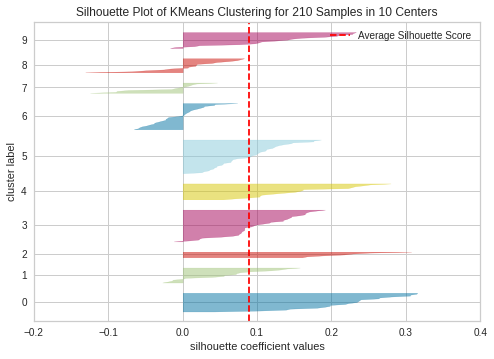

Num cluster  16  Silhoutte score   =  [ 0.21506079  0.20881368  0.21187639 -0.00731947 -0.08742791 -0.00457771
  0.13826603 -0.00290043 -0.04938928  0.14079958  0.04683288  0.152317
  0.15254101  0.24949276  0.04594046  0.01703845  0.10316116  0.10893331
  0.05631893  0.07566036  0.0285201   0.13185713  0.23847139  0.07956041
  0.08150567 -0.05856396  0.02157936  0.00625297 -0.00543294  0.02063334
  0.07041389  0.06679121  0.05377938  0.14527628  0.31235528 -0.03344325
 -0.02750551 -0.02991362  0.0478017   0.02807571 -0.04018578 -0.10546319
  0.15091306 -0.02155799  0.05861549 -0.10976411  0.05149619  0.06083308
  0.01204612  0.07127532  0.02179527 -0.04208414  0.0584297   0.02071455
 -0.0762466   0.18121037  0.1633331   0.10604893  0.06278149  0.06034948
  0.1758945   0.07668424  0.21323094  0.07334629 -0.04101409  0.14700432
 -0.02709227 -0.01644462  0.07402226  0.18758212  0.05656873  0.20190448
  0.002554    0.07433958  0.10681247 -0.03179207  0.00803213  0.0939359
  0.1494128   0.

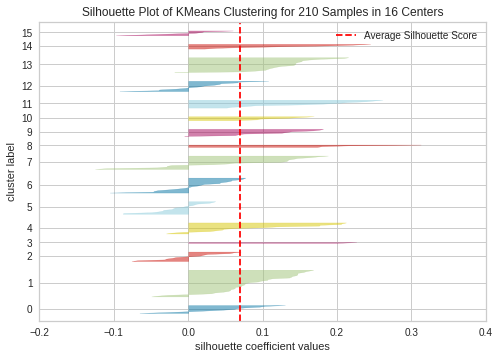

Num cluster  36  Silhoutte score   =  [-5.44847921e-02 -7.60920579e-03  1.63699850e-01  1.35734707e-01
 -4.64455821e-02 -1.34602282e-02  8.61167759e-02 -4.76934351e-02
  6.38778359e-02 -3.49055231e-02 -3.11823376e-02  3.65022235e-02
  9.32759121e-02  1.79104924e-01  6.87953681e-02 -3.21982279e-02
  8.26397017e-02  6.41383603e-02  1.14596821e-02  1.21666770e-02
  6.92054853e-02  1.07627459e-01  2.10061684e-01 -2.41484903e-02
  7.06990389e-03  8.89700428e-02 -2.39725895e-02 -8.52523651e-03
  1.82518363e-01  9.46086124e-02  1.55939059e-02  8.26655775e-02
  5.23784347e-02  3.22821550e-02  3.38193208e-01 -5.08604012e-02
  8.57358426e-03  7.54483230e-03 -5.02018444e-02  1.80937466e-03
  1.14675187e-01 -6.79567084e-02  2.52093058e-02 -1.11128531e-01
  2.03475505e-01  6.02918193e-02  9.70379040e-02 -3.62332305e-03
  4.59481366e-02 -9.42937806e-02  1.67311147e-01 -2.25748066e-02
  8.11008438e-02  1.87650308e-01  1.07014887e-02  1.02831803e-01
  7.00281337e-02  5.91358989e-02  2.54801158e-02  9.

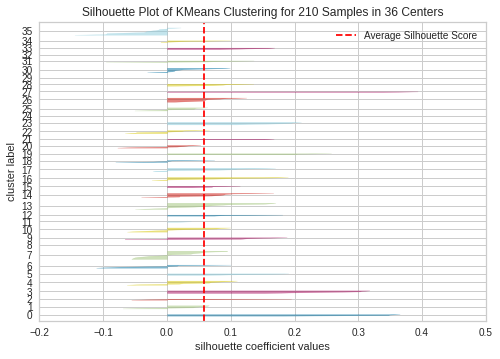

Num cluster  64  Silhoutte score   =  [-4.41522487e-02 -1.31746484e-02  1.94434360e-01  0.00000000e+00
  6.85807690e-02 -3.61842439e-02  8.71542618e-02 -9.98383667e-03
  1.33977481e-03 -6.43457547e-02  3.54233310e-02  5.39828204e-02
  6.55000731e-02  2.85380065e-01  8.78263861e-02  0.00000000e+00
  6.80333227e-02  8.10221583e-03  9.10251662e-02  5.85340783e-02
  1.23758595e-02  1.12921551e-01  2.75521696e-01  0.00000000e+00
 -1.79795325e-02  8.92061517e-02  4.35799994e-02  4.17393558e-02
  1.71997860e-01  5.67916557e-02  7.01956525e-02  5.30071706e-02
  1.64621174e-01 -1.99684370e-02  3.33391160e-01 -8.69132951e-02
  1.99598908e-01 -7.80516351e-03 -6.55754730e-02  0.00000000e+00
  2.21363932e-01 -3.34610268e-02  1.15011655e-01  1.80853084e-01
  7.84212351e-02  5.83950169e-02 -8.18165243e-02  0.00000000e+00
 -1.93341461e-03  0.00000000e+00  2.70983111e-02  3.77183519e-02
 -4.04640287e-02  3.29644799e-01 -6.25152513e-03  1.86758518e-01
  3.99967171e-02  1.61771923e-01 -6.27099425e-02  1.

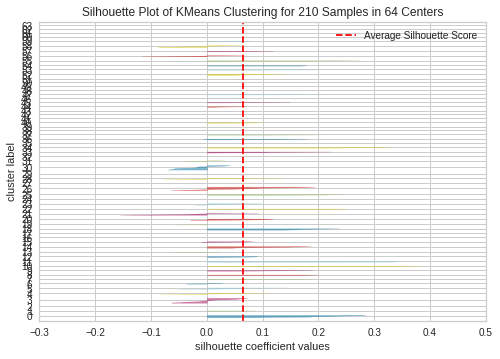

Num cluster  144  Silhoutte score   =  [ 1.27851382e-01  6.18846454e-02  2.33759016e-01  0.00000000e+00
  4.10993909e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.17228581e-02  3.30684111e-02 -1.89552177e-02
  0.00000000e+00  1.06032498e-01  6.93068793e-03  0.00000000e+00
  3.76764336e-03  0.00000000e+00  2.61833034e-02  0.00000000e+00
  5.37339412e-02 -9.21207964e-02 -3.05172745e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.93205267e-01 -3.41282748e-02
  7.11390376e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.97821093e-02  0.00000000e+00  3.33391160e-01  1.18939811e-03
  7.55798519e-02  0.00000000e+00  1.21381789e-01  0.00000000e+00
  0.00000000e+00 -1.01252832e-01  1.34867713e-01  5.19249402e-02
  0.00000000e+00  8.35208818e-02  6.02717884e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.50158063e-01
  1.53101966e-01  2.92309254e-01  5.89764342e-02  0.00000000e+00
  0.00000000e+00  3.15371272e-03  1.10887559e-02  0

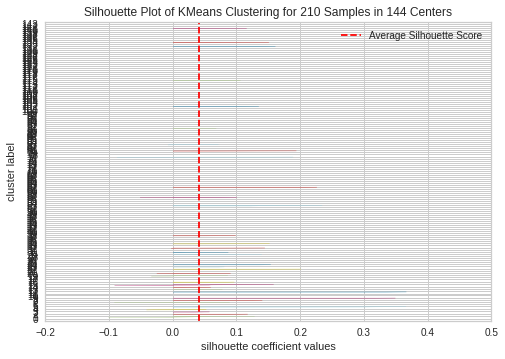

Num cluster  200  Silhoutte score   =  [0.11342616 0.00224654 0.2284009  0.         0.         0.
 0.         0.         0.         0.         0.         0.04992695
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.29230925
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.34851322 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 

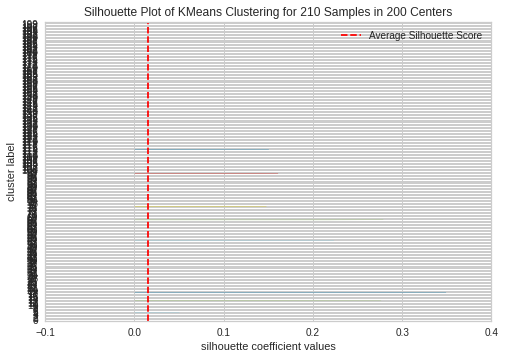

In [58]:
from yellowbrick.cluster.silhouette import silhouette_visualizer

#fig, ax = plt.subplots(3, 2, figsize=(15,8))
j = 2
for i in clusters:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', random_state=42)
    km.fit(x)
    score = silhouette_samples(x, km.labels_, metric='euclidean')
    print('Num cluster ',i,' Silhoutte score   = ',score)
    q, mod = divmod(j, 2)
    j+=1
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = silhouette_visualizer(km, colors='yellowbrick',X=x,y=label, is_fitted='auto',show=True)


Num cluster  10  Silhoutte score   =  0.088951595


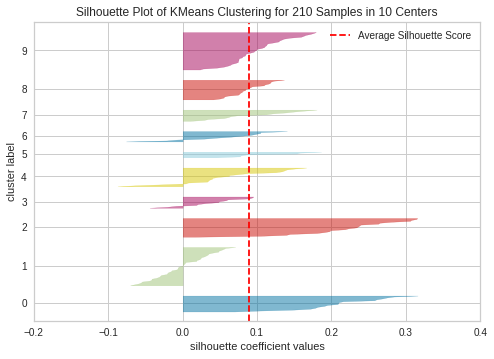

In [53]:
km = KMeans(n_clusters=10)
km.fit(x)
score = silhouette_score(x, km.labels_, metric='euclidean')
print('Num cluster ',10,' Silhoutte score   = ',score)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(x)
visualizer.show()

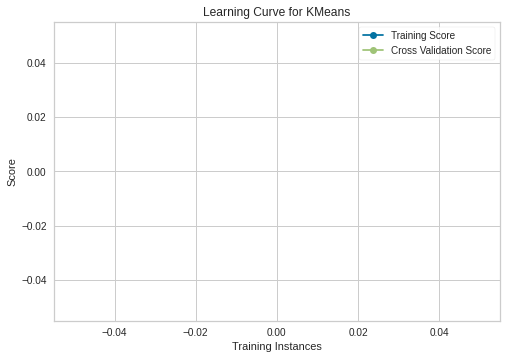

In [39]:

from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(km, scoring="adjusted_rand_score", random_state=42)
visualizer.fit(x, label) 
visualizer.show()  

In [40]:
count = [len(groups[i]) for i in groups.keys()]
count

[36, 18, 35, 15, 20, 20, 20, 13, 15, 18]

In [41]:
df.groupby('label').size()

label
0    21
1    20
2    19
3    22
4    21
5    25
6    23
7    15
8    26
9    18
dtype: int64

In [59]:
n_feat = [100,150,200,210]
for n_components in n_feat:
    print('Results for PCA == ',n_components)
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(feat)
    x = pca.transform(feat)

    kmeans = KMeans(n_clusters=10)
    kmeans.fit(x)
    
   
    iner_list.append(kmeans.inertia_)
    
    
    # Determine predicted labels
    cluster_labels = infer_cluster_labels(kmeans, label)
    prediction = infer_data_labels(kmeans.labels_, cluster_labels)
    homo = classifier_summary(label, prediction)
    homo_list.append(homo)

    acc = accuracy_score(label, prediction)
    acc_list.append(acc)

Results for PCA ==  100


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 65.24%
F1_score : 0.6286
Cohen Kappa Score : 0.6126 
Recall : 0.6524
Precision : 0.6955
Humogeneity : 0.5869
Confusion Matrix : [[15  2  0  0  0  3  0  0  1  0]
 [ 0 15  0  0  0  0  0  0  5  0]
 [ 0  1 18  0  0  0  0  0  0  0]
 [10  6  0  5  0  1  0  0  0  0]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 2  1  0  0  1 21  0  0  0  0]
 [ 4  0  0  0  0  5 14  0  0  0]
 [ 0  0  1  0  0  0  0 14  0  0]
 [ 5  4  0  0  0  2  0  0 15  0]
 [ 5 10  0  0  0  3  0  0  0  0]]
--------------------------------------------------------------------------------

Results for PCA ==  150


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 57.620000000000005%
F1_score : 0.5173
Cohen Kappa Score : 0.5286 
Recall : 0.5762
Precision : 0.4954
Humogeneity : 0.5349
Confusion Matrix : [[15  0  0  0  0  5  0  0  1  0]
 [ 3  5  0  0  0  1  0  0  5  6]
 [ 0  0 19  0  0  0  0  0  0  0]
 [10  5  0  0  0  1  0  0  0  6]
 [ 0  0  1  0 20  0  0  0  0  0]
 [ 2  0  0  0  0 23  0  0  0  0]
 [12  5  0  0  0  5  0  0  0  1]
 [ 0  0  1  0  0  0  0 14  0  0]
 [ 7  0  0  0  0  3  0  1 13  2]
 [ 0  1  0  0  0  5  0  0  0 12]]
--------------------------------------------------------------------------------

Results for PCA ==  200


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



------------------------ Test Set Metrics------------------------

accuracy : 61.9%
F1_score : 0.5664
Cohen Kappa Score : 0.5745 
Recall : 0.619
Precision : 0.5609
Humogeneity : 0.5832
Confusion Matrix : [[ 0  2  0  0  0  3  0  0 16  0]
 [ 0 15  0  0  0  0  5  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  1  5  0  3  0]
 [ 0  0  0  0 21  0  0  0  0  0]
 [ 0  2  0  0  0 22  0  0  1  0]
 [ 0  1  0  0  0  5 14  0  3  0]
 [ 0  0  1  0  0  0  0 14  0  0]
 [ 0  7  0  0  0  2  0  0 17  0]
 [ 0  5  0  0  0  4  0  0  1  8]]
--------------------------------------------------------------------------------

Results for PCA ==  210

------------------------ Test Set Metrics------------------------

accuracy : 62.38%
F1_score : 0.5867
Cohen Kappa Score : 0.5825 
Recall : 0.6238
Precision : 0.6016
Humogeneity : 0.5845
Confusion Matrix : [[15  3  0  0  0  3  0  0  0  0]
 [ 0 14  0  5  0  0  0  0  0  1]
 [ 0  1 18  0  0  0  0  0  0  0]
 [ 6  4  0  7  0  1  0  0  0  4]
 [ 0  0  1  0 20  0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
